# Lamprey Transcriptome Analysis: Gene Model Overlap Notebook

```
Camille Scott [camille dot scott dot w @gmail.com] [@camille_codon]

camillescott.github.io

Lab for Genomics, Evolution, and Development
Michigan State University
```

## About

Explores consensus between assembled transcripts and existing lamprey gene models, using the `gtf_to_genes` library.

    assembly version: lamp10

    assembly program: Trinity
    
    gtf model versin: 7.0.75
    
There is another script in this directory called `petmar-gtf-overlap.py` which loads the database and does the `apply` function to query overlaps for each hit, as those operations take a very long time (these are a definite target for optimization).

In [1]:
!echo $PWD

/home/camille/lamprey/2015-petMarSB/notebooks


## Contents

1. [Libraries](#Libraries) 
* [Data Loading](#Data-Loading)
* [Matplotlib RC Settings](#Matplotlib-RC-Settings)
* [Existing Gene Models](#Existing-Gene-Models)
     1. [Interval Query Initialization](#Interval-Query-Initialization)
     * [Utility Functions](#Utility-Functions)
     * [Results](#Results)

## Libraries

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from libs import *
%run -i common.ipy

** Using data resources found in ../resources.json
** Using config found in ../config.json


In [4]:
from bx.intervals.intersection import Interval, Intersecter, IntervalTree

In [5]:
from IPython.html.widgets import interactive, RadioButtonsWidget
from IPython.display import display
from IPython.html import widgets

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [6]:
import pyprind

In [7]:
from gtftools import read_gtf

In [9]:
from blasttools import blast_to_df
import intervaltools as ivt

## Matplotlib RC Settings

In [159]:
%pylab inline
from matplotlib import rc_context
tall_size = (8,16)
norm_size = (12,8)
mpl_params = {'figure.autolayout': True,
               'axes.titlesize': 24,
               'axes.labelsize': 16,
               'ytick.labelsize': 14,
               'xtick.labelsize': 14
               }
sns.set(style="white", palette="Paired", rc=mpl_params)
#sns.set_palette("Paired", desat=.6)
b, g, r, p = sns.color_palette("muted", 4)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [11]:
%config InlineBackend.close_figures = False

## Data Loading

In [12]:
store = pd.HDFStore(wdir('{}.store.h5'.format(prefix)), complib='zlib', complevel=5)

In [13]:
lamp10_db = screed.ScreedDB(wdir(resources_df.filename['lamp10']))
lamp00_db = screed.ScreedDB(wdir(resources_df.filename['petMar2_cdna']))

In [14]:
lamp00_pM_df = blast_to_df(wdir('{}.fa.x.{}.db.tsv'.format('petMar2.cdna', 'petMar2.fa')), index_col=None)
lamp00_pM_df.sort(columns=['sseqid'], inplace=True)
lamp00_pM_df.index.set_names('aln_id', inplace=True)
lamp00_pM_df.head()

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,qstrand,sstrand
aln_id,,,,,,,,,,,,,,
1763,ENSPMAT00000006415,GL476328,87.14,70,8,1,1410,1479,904657,904727,3.000000e-12,78.7,+,+
1764,ENSPMAT00000006415,GL476328,97.14,35,1,0,1487,1522,139410,139445,1.000000e-06,60.2,+,+
2487,ENSPMAT00000006543,GL476328,96.83,63,1,1,1683,1745,732138,732201,5.000000e-20,104.0,+,+
2488,ENSPMAT00000006543,GL476328,92.65,68,2,2,1679,1744,149678,149746,3.000000e-17,95.3,+,-
2489,ENSPMAT00000006543,GL476328,93.75,64,2,1,1682,1744,1006401,1006465,3.000000e-17,95.3,+,+


In [15]:
lamp10_pM_df = blast_to_df(wdir('{}.fasta.x.{}.db.tsv'.format('lamp10', 'petMar2.fa')), index_col=None)
lamp10_pM_df.sort(columns=['sseqid'], inplace=True)
lamp10_pM_df.index.set_names('aln_id', inplace=True)
lamp10_pM_df.head()

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,qstrand,sstrand
aln_id,,,,,,,,,,,,,,
1942,c35304_g1_i1,GL476328,92.68,41,3,0,612,653,388244,388285,4.000000e-07,60.2,+,+
1944,c35304_g1_i2,GL476328,92.68,41,3,0,208,249,388244,388285,1.000000e-07,60.2,+,+
2886,c220917_g1_i2,GL476328,100.00,33,0,0,85,118,1278050,1278083,6.000000e-08,62.1,+,-
3802,c131063_g1_i1,GL476328,99.31,432,1,1,18,450,806166,806596,0.000000e+00,780.0,+,-
3809,c131063_g1_i2,GL476328,99.14,350,1,1,16,366,806166,806514,1.000000e-178,628.0,+,-


In [163]:
gtf_file = wdir(resources_df.ix['petMar2_gtf'].filename)
gtf_df = read_gtf(gtf_file)
gtf_df.sort(columns=['contig_id'], inplace=True)
gtf_df.index.set_names('ann_id', inplace=True)
gtf_df['feature_length'] = gtf_df.end - gtf_df.start
gtf_df.head()

,contig_id,source,feature,start,end,score,strand,frame,exon_id,exon_number,gene_biotype,gene_id,gene_name,gene_source,protein_id,transcript_id,transcript_name,transcript_source,feature_length
ann_id,,,,,,,,,,,,,,,,,,,
5124,GL476328,protein_coding,gene,168846,169476,.,+,.,NaN,NaN,protein_coding,ENSPMAG00000010374,cdkn1c,ensembl,NaN,NaN,NaN,NaN,630
5125,GL476328,protein_coding,transcript,168846,169476,.,+,.,NaN,NaN,protein_coding,ENSPMAG00000010374,cdkn1c,ensembl,NaN,ENSPMAT00000011401,cdkn1c-201,ensembl,630
5126,GL476328,protein_coding,exon,168846,169476,.,+,.,ENSPMAE00000096602,1,protein_coding,ENSPMAG00000010374,cdkn1c,ensembl,NaN,ENSPMAT00000011401,cdkn1c-201,ensembl,630
5127,GL476328,protein_coding,CDS,168846,169476,.,+,0,NaN,1,protein_coding,ENSPMAG00000010374,cdkn1c,ensembl,ENSPMAP00000011355,ENSPMAT00000011401,cdkn1c-201,ensembl,630
5128,GL476328,protein_coding,gene,235293,235778,.,-,.,NaN,NaN,protein_coding,ENSPMAG00000007839,rps4x,ensembl,NaN,NaN,NaN,NaN,485


In [17]:
tpm_df = store['tpm_df']

In [18]:
blast_panel = store['blast_panel']
blast_df = store['blast_df']

Test stuff out with a small subset

In [19]:
gtf_df_small = gtf_df.tail(10000)
lamp10_pM_df_small = lamp10_pM_df.tail(100000)

In [20]:
gtf_df_small.index.set_names('ann_id', inplace=True)
lamp10_pM_df_small.index.set_names('aln_id', inplace=True)

In [21]:
gtf_trees_small = gtf_df_small.groupby('contig_id').apply(ivt.build_tree_from_group, gtf_df, ivt.get_gtf_coords)
alignment_subject_trees_small = lamp10_pM_df_small.groupby('sseqid').apply(
                                                                ivt.build_tree_from_group, lamp10_pM_df,
                                                                ivt.get_blast_subject_coords)

In [22]:
gtf_trees_small.name = 'annotations'
alignment_subject_trees_small.name = 'alignments'
gi_df_small = pd.concat([gtf_trees_small, alignment_subject_trees_small], axis=1)

In [23]:
overlap_data_small = ivt.get_gtf_aln_overlap_df(gi_df_small)

In [24]:
gtf_aln_df_small = gtf_df_small.join(overlap_data_small).join(lamp10_pM_df_small).sortlevel()

In [25]:
gtf_aln_df_small['ann_length'] = gtf_aln_df_small.end - gtf_aln_df_small.start
gtf_aln_df_small['aln_overlap_prop'] = gtf_aln_df_small.overlap_len / gtf_aln_df_small.length
gtf_aln_df_small['ann_overlap_prop'] = gtf_aln_df_small.overlap_len / gtf_aln_df_small.ann_length

In [26]:
(gtf_aln_df_small.ann_overlap_prop > 1).sum()

0

## Gene Models from Pmarinus 7.0.75

### Build Interval Trees

Build an IntervalTree of BLAST alignments to each contig

In [27]:
bar = pyprind.ProgBar(len(lamp10_pM_df), stream=1, title='Build BLAST interval trees')
alignment_subject_trees = lamp10_pM_df.groupby('sseqid').apply(ivt.build_tree_from_group, lamp10_pM_df,
                                                               ivt.get_blast_subject_coords, bar=bar)

Build BLAST interval trees
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 564.936 sec


Build an IntervalTree of GTF features for each contig

In [28]:
bar = pyprind.ProgBar(len(gtf_df), stream=1, title='Build GTF interval trees')
gtf_trees = gtf_df.groupby('contig_id').apply(ivt.build_tree_from_group, gtf_df, ivt.get_gtf_coords, bar=bar)

Build GTF interval trees
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 37.767 sec


Combine both Series of IntervalTrees into one DataFrame keyed by the contig id

In [29]:
gtf_trees.name = 'annotations'
alignment_subject_trees.name = 'alignments'
genome_interval_df = pd.concat([gtf_trees, alignment_subject_trees], axis=1)

### Sanity Check

In [49]:
ann_self_overlap = ivt.check_ann_covered_single(gtf_df, gtf_trees)

In [52]:
float(ann_self_overlap.sum()) / ann_self_overlap.size

1.0

Good, it appears to work!

### Calculate Overlap Data

In [199]:
bar = pyprind.ProgBar(len(genome_interval_df), stream=1, title='Calculating overlaps')
ann_aln_ov_df = ivt.get_ann_aln_overlap_df(genome_interval_df, cutoff=0.9, bar=bar)

Calculating overlaps
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 12.674 sec


In [200]:
store['lamp10_ann_aln_ov_df'] = ann_aln_ov_df

In [201]:
bar = pyprind.ProgBar(len(genome_interval_df), stream=1, title='Calculating overlaps')
aln_ann_ov_df = ivt.get_aln_ann_overlap_df(genome_interval_df, cutoff=0.9, bar=bar)

Calculating overlaps
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 17.868 sec


In [197]:
store['lamp10_aln_ann_ov_df'] = aln_ann_ov_df

### Quantify Overlaps

First we calculate whether each annotation is overlapped at least 90% by a single transcript

In [43]:
ann_overlap_vec = ivt.check_ann_covered_single(gtf_df, alignment_subject_trees)

In [48]:
float(ann_overlap_vec.sum()) / ann_overlap_vec.size

0.714577648340084

Hmm, this result isn't very good. How do things look by feature?

In [53]:
ann_overlap_vec.groupby(gtf_df.feature).apply(lambda g: float(g.sum()) / g.size)

feature
CDS            0.788948
UTR            0.837687
exon           0.779816
gene           0.128727
start_codon    0.857505
stop_codon     0.903922
transcript     0.120359
dtype: float64

A bit better! The `gene` and `transcript` features are course-grained (their intervals contain introns), and are unlikely to be overlapped 90% by any single transcript.

In [65]:
ann_overlap_vec.groupby(gtf_df.feature).count()

feature
CDS            101975
UTR              3216
exon           105480
gene            13113
start_codon      3158
stop_codon       4080
transcript      14141
dtype: int64

How about when we allow for multiple alignments to be merged to meet the .9 cutoff?

In [141]:
ann_covered_vec = ivt.check_ann_covered(gtf_df, alignment_subject_trees)

In [142]:
float(ann_covered_vec.sum()) / ann_covered_vec.size

0.7482368872953913

In [143]:
ann_covered_vec.groupby(gtf_df.feature).apply(lambda g: float(g.sum()) / g.size)

feature
CDS            0.822555
UTR            0.881841
exon           0.815425
gene           0.163578
start_codon    0.857505
stop_codon     0.903922
transcript     0.153596
dtype: float64

The numbers see some marked improvement. Finally, let's look at how they change with decreasing cutoffs.

In [147]:
cutoffs = pd.Series(np.arange(0.0, 1.1, .1))
def coverage_fn(cutoff):
    s = ivt.check_ann_covered(gtf_df, alignment_subject_trees, cutoff=cutoff)
    s.name = cutoff
    return s
ann_covered_df = cutoffs.apply(lambda c: coverage_fn(c))
ann_covered_df = ann_covered_df.transpose()

In [148]:
ann_covered_df.columns = cutoffs

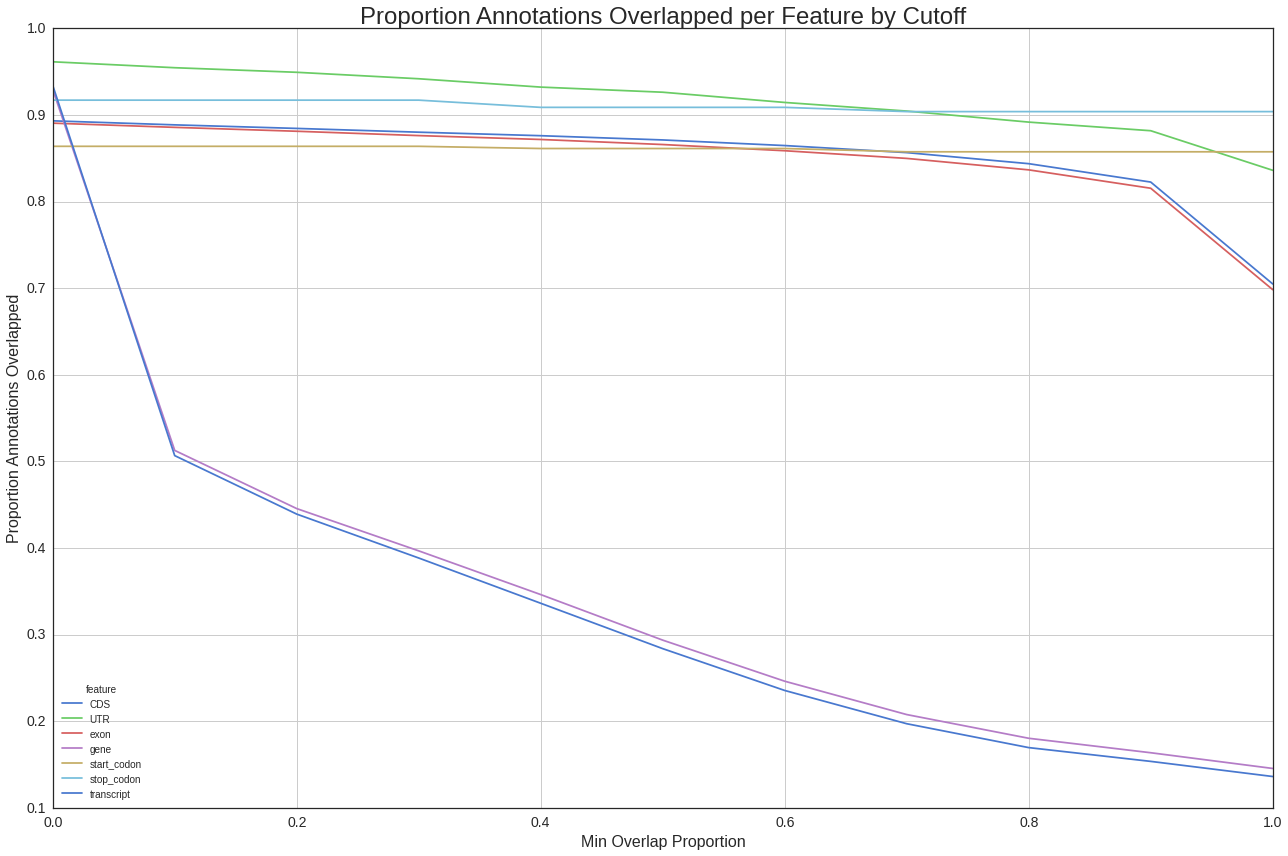

In [190]:
with sns.color_palette('muted'), FigManager() as (fig, ax):
    ann_covered_df.groupby(gtf_df.feature).apply(lambda g: g.sum() / len(g)).T.plot(ax=ax)
    ax.set_ylabel('Proportion Annotations Overlapped')
    ax.set_xlabel('Min Overlap Proportion')
    ax.set_title('Proportion Annotations Overlapped per Feature by Cutoff')

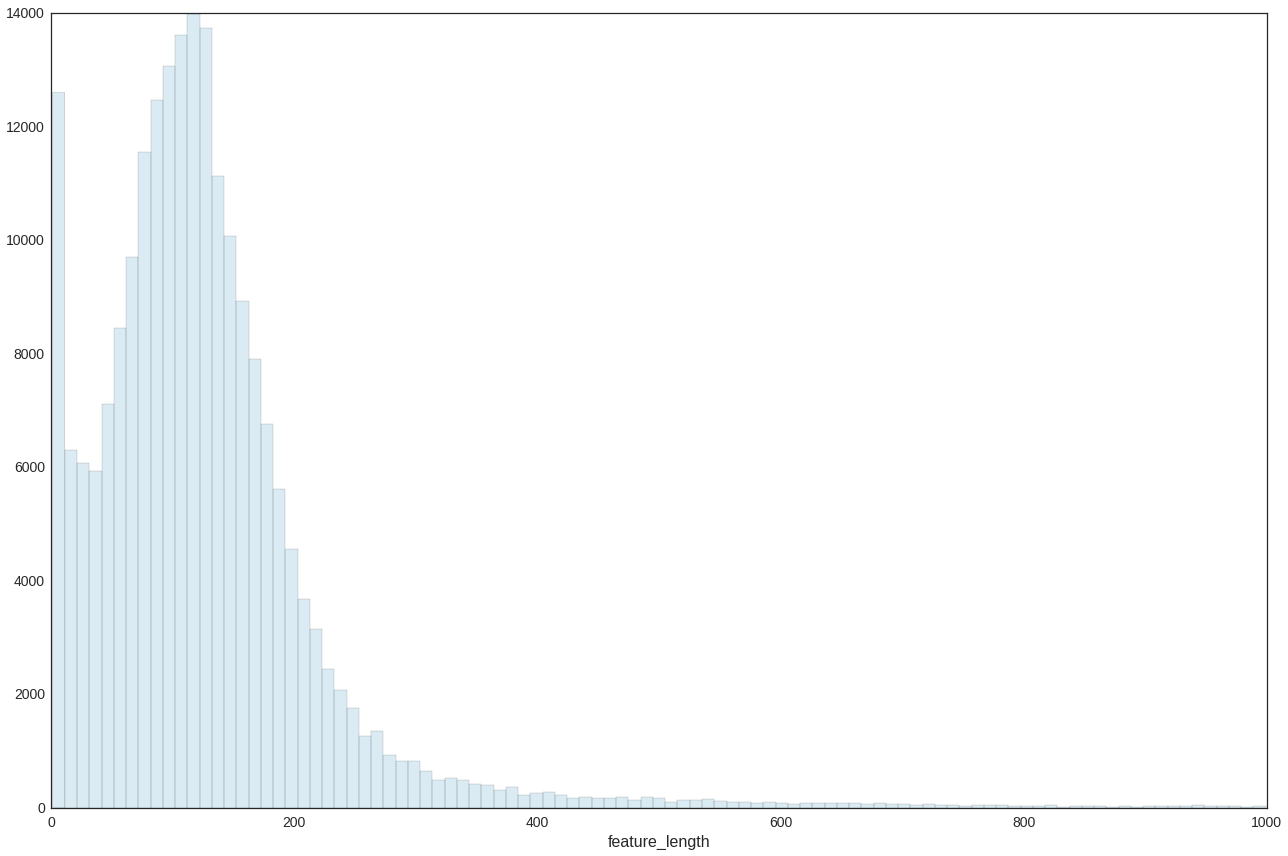

In [189]:
with FigManager() as (fig, ax):
    gtf_subs_df = gtf_df[(gtf_df.feature.isin(['transcript', 'gene']) == False) & (gtf_df.feature_length < 1000)]
    bins = np.linspace(gtf_subs_df.feature_length.min(), gtf_subs_df.feature_length.max(), 100)
    groups = ann_covered_vec[gtf_subs_df.index].groupby(pd.cut(gtf_subs_df.feature_length, bins))
    
    sns.distplot(gtf_subs_df.feature_length, kde=False, bins=bins)

### Describe Overlaps

Retrieve the indices of each overlapping transcript for each feature

Join the metadata from the features and corresponding overlapped alignments

In [32]:
overlap_df = gtf_df.join(overlap_data).join(lamp10_pM_df).sortlevel()

In [33]:
overlap_df['ann_length'] = overlap_df.end - overlap_df.start
overlap_df['aln_overlap_prop'] = overlap_df.overlap_len / overlap_df.length
overlap_df['ann_overlap_prop'] = overlap_df.overlap_len / overlap_df.ann_length

In [34]:
overlap_df.head()

contig_id          source feature   start     end score strand  \
ann_id aln_id                                                                  
5124   616481  GL476328  protein_coding    gene  168846  169476     .      +   
       616484  GL476328  protein_coding    gene  168846  169476     .      +   
       616490  GL476328  protein_coding    gene  168846  169476     .      +   
       616493  GL476328  protein_coding    gene  168846  169476     .      +   
       616497  GL476328  protein_coding    gene  168846  169476     .      +   

              frame exon_id exon_number       ...         qend  sstart  \
ann_id aln_id                                 ...                        
5124   616481     .     NaN         NaN       ...         1783  169341   
       616484     .     NaN         NaN       ...         2070  169341   
       616490     .     NaN         NaN       ...          763  169341   
       616493     .     NaN         NaN       ...         2557  169341   
       616497     .     NaN         NaN       ...         1260  169341   

                 send evalue bitscore qstrand sstrand ann_length  \
ann_id aln_id                                                      
5124   616481  169723      0      652       +       -        630   
       616484  169723      0      652       +       -        630   
       616490  169723      0      652       +       -        630   
       616493  169723      0      652       +       -        630   
       616497  169723      0      652       +       -        630   

               aln_overlap_prop ann_overlap_prop  
ann_id aln_id                                     
5124   616481          0.350649         0.214286  
       616484          0.350649         0.214286  
       616490          0.350649         0.214286  
       616493          0.350649         0.214286  
       616497          0.350649         0.214286  

[5 rows x 36 columns]

#### How many transcripts overlap a feature at all?

In [35]:
tr_intersecting = (overlap_df.reset_index().groupby('qseqid')['ann_id'].count() > 0).sum()
tr_total = len(tpm_df)
print '{} of {} transcripts overlap a GTF feature ({:.2f})'.format(tr_intersecting, tr_total, 
                                                                   float(tr_intersecting) / tr_total)

218160 of 715345 transcripts overlap a GTF feature (0.30)


#### How big are the overlaps?

We can easily examine the proportion of a given sequence overlapped, be it a transcript (ie, how much of the transcript was overlapped by the specific feature) or an annotation. We can also subset the annotations by feature type.

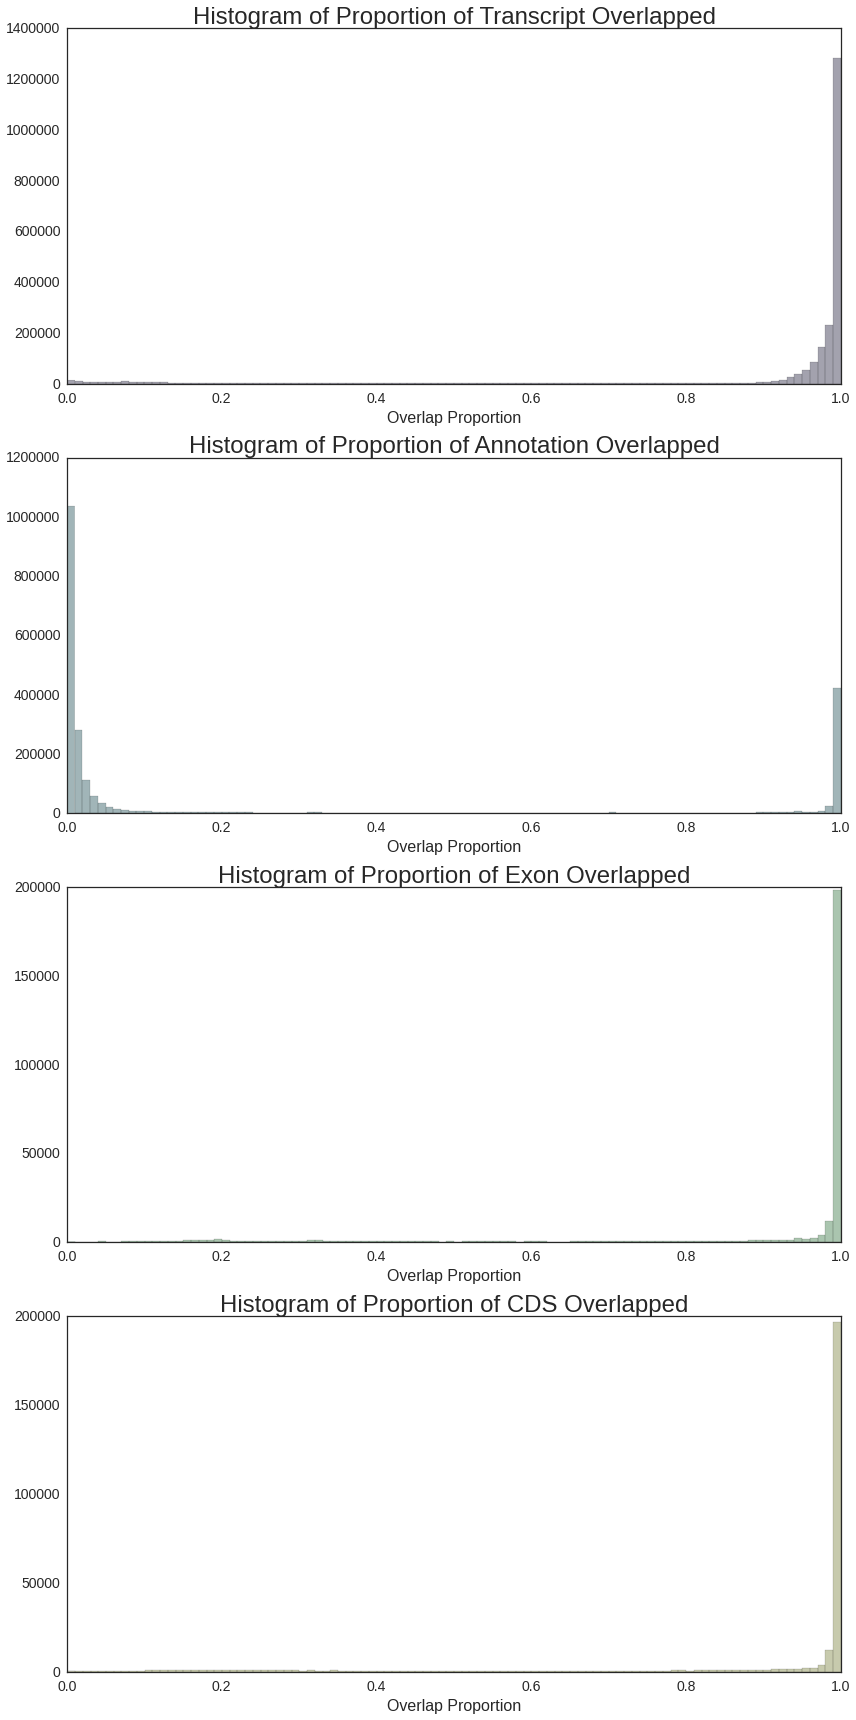

In [36]:
with FigManager(nrows=4, figsize=(12,24)) as (fig, ax):
    colors = sns.color_palette("cubehelix", 8)
    sns.distplot(overlap_df.aln_overlap_prop.dropna(), ax=ax[0], kde=False, bins=100, color=colors[0],
                 axlabel='Overlap Proportion')
    ax[0].set_title('Histogram of Proportion of Transcript Overlapped')
    
    sns.distplot(overlap_df.ann_overlap_prop.dropna(), ax=ax[1], kde=False, bins=100, color=colors[1], 
                 axlabel='Overlap Proportion')
    ax[1].set_title('Histogram of Proportion of Annotation Overlapped')
 
    sns.distplot(overlap_df[overlap_df.feature == 'exon'].ann_overlap_prop.dropna(), ax=ax[2], color=colors[2],
                 kde=False, bins=100, axlabel='Overlap Proportion')
    ax[2].set_title('Histogram of Proportion of Exon Overlapped')

    sns.distplot(overlap_df[overlap_df.feature == 'CDS'].ann_overlap_prop.dropna(), ax=ax[3], color=colors[3],
                 kde=False, bins=100, axlabel='Overlap Proportion')
    ax[3].set_title('Histogram of Proportion of CDS Overlapped')

### WIP: Abundance + cross validation

In [119]:
tpm_df['ann_id'] = False
tpm_df.update((gtf_aln_df.reset_index().groupby('qseqid')['ann_id'].count() > 0))
tpm_df.rename(columns={'ann_id':'has_annotation'}, inplace=True)

In [121]:
tpm_df['mean_tpm'] = tpm_df.drop('has_annotation', axis=1).mean(axis=1)

In [165]:
tpm_df[tpm_df.has_annotation == True].mean_tpm.median()

0.7561955235359132

In [166]:
tpm_df[tpm_df.has_annotation == False].mean_tpm.median()

0.7595900362358685

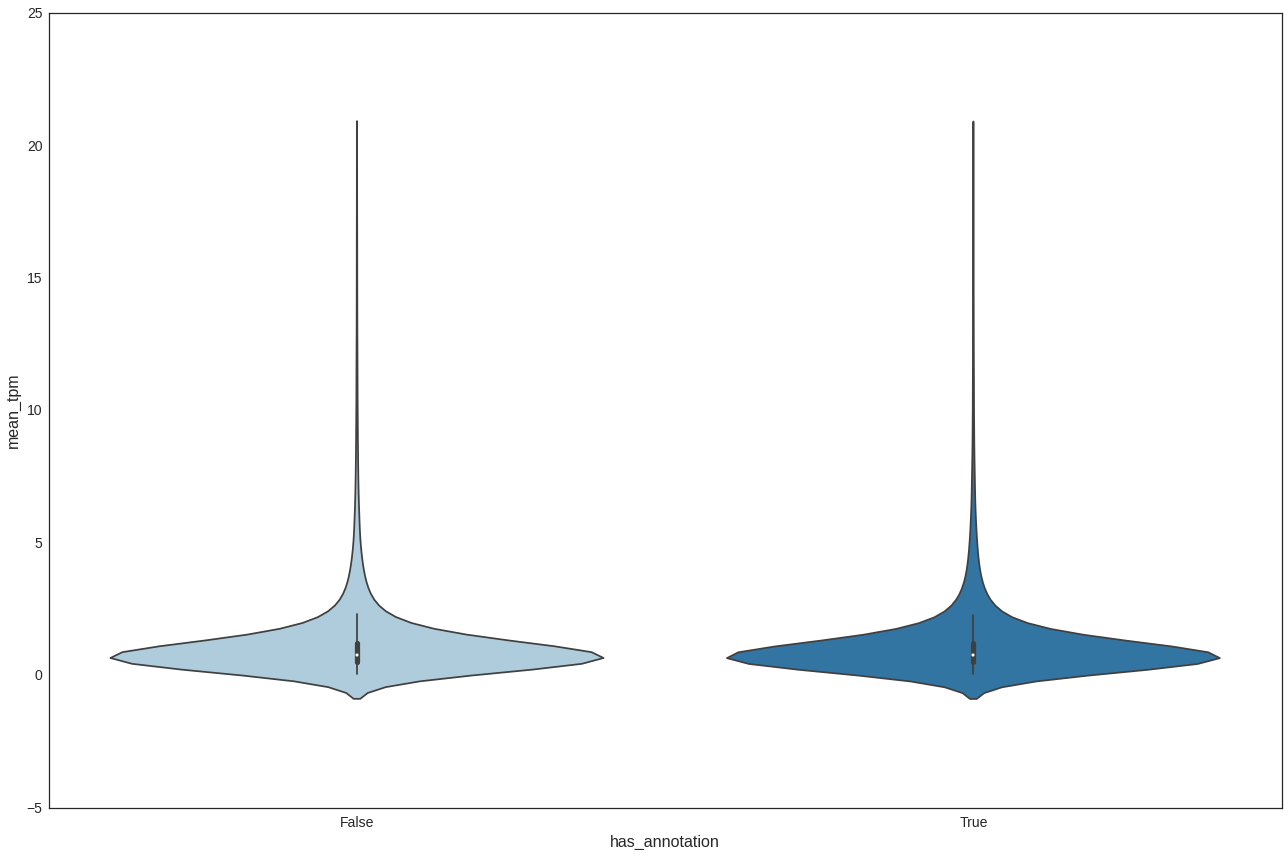

In [164]:
with FigManager() as (fig, ax):
    sns.violinplot(x='has_annotation', y='mean_tpm', data=tpm_df[tpm_df.mean_tpm < 20], ax=ax, bw=.3)

In [233]:
store.close()

### Deprecated

### Utility Functions

Given a genome contig and a range, get the appropriate interval tree and find overlapping intervals. Return the DataFrame indices for matching features.

In [24]:
def describe_overlap(qstart, qend, istart, iend, delta=2):
    qlen = qend - qstart
    ilen = iend - istart
    
    if qstart == istart and qend == iend:
        return 'exact', qlen, 1.0
    
    elif qstart >= istart:
        if qend <= iend:
            return 'contained', qlen, 1.0
        else:
            olen = iend - qstart
            return 'overlaps', olen, float(olen) / qlen
    else:
        if qend <= iend:
            olen = qend - istart
            return 'overlaps', olen, float(olen) /qlen
        else:
            return 'contains', ilen, 1.0

In [25]:
# Tests!
assert describe_overlap(5,10,0,15) == ('contained', 5, 1.0)
assert describe_overlap(0,15,5,10) == ('contains', 5, 1.0)
assert describe_overlap(0,10,5,15) == ('overlaps', 5, .5)
assert describe_overlap(5,15,0,10) == ('overlaps', 5, .5)
assert describe_overlap(0,10,0,10) == ('exact', 10, 1.0)

In [26]:
def get_overlap_rows(seqname, start, end, db, overlaps):
    try:
        tree = db[seqname]
    except Exception as e:
        #print >>sys.stderr, 'No interval tree for sequence', seqname, e
        return []
    # Turns out the intervaltree requires (min,max) style coordinates
    rows = []
    for interval in tree[min(start,end):max(start,end)]:
        ix, feature = interval.data
        rows.append(ix)
        overlaps.append(describe_overlap(min(start, end), max(start, end), interval.begin, interval.end) + (feature, ))
        
    return rows

In [27]:
def get_overlaps(df, db, block_size=5000):
    bar = pyprind.ProgBar(len(df) / block_size, stream=1)
    
    df['features'] = None
    overlaps = []
    for block_start in range(0,len(df), block_size):
        bar.update()
        df.ix[block_start:block_start+block_size, 'features'] = \
            df.ix[block_start:block_start+block_size].apply(
            lambda row: get_overlap_rows(row.sseqid, row.sstart, row.send, db, overlaps), axis=1)
    
    odf = pd.DataFrame(overlaps, columns=['overlap_type', 'length', 'percent', 'feature'])
    return odf

In [28]:
def quantify_overlaps(df, gtf_df=gtf_df):
    df['tr'] = df.index
    df.sort(columns=['tr', 'sseqid'], inplace=True)
    
    overlapped_rows = set()
    df.apply(lambda row: overlapped_rows.update(row.features), axis=1)
    
    stats_srs = gtf_df.ix[list(overlapped_rows)].groupby(by='feature').count().source / \
               gtf_df.groupby(by='feature', axis=0).count().source
    stats_srs = stats_srs.append(pd.Series(float(len(overlapped_rows)) / len(gtf_df), index=['all']))
    
    for feature, perc in stats_srs.iteritems():
        print '{:.2f}% of {:s} features overlapped'.format(perc * 100.0, feature)
    return stats_srs

In [35]:
lamp00_overlaps = get_overlaps(lamp00_pM_df, petMar2_idb)

0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 16.920 sec


In [36]:
lamp00_stats_srs = quantify_overlaps(lamp00_pM_df)

91.98% of CDS features overlapped
96.27% of UTR features overlapped
89.69% of exon features overlapped
79.88% of gene features overlapped
95.00% of start_codon features overlapped
98.04% of stop_codon features overlapped
81.35% of transcript features overlapped
89.93% of all features overlapped


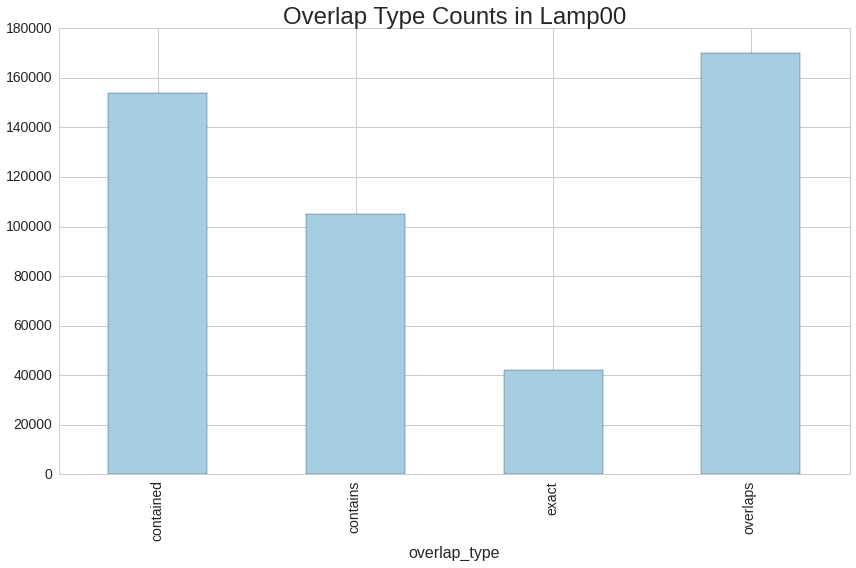

/home/camille/w/2015-petMarSB/notebooks/lamp00_overlap_type_counts.svg

In [44]:
with FigManager('lamp00_overlap_type_counts', figsize=norm_size, show=True) as (fig, ax):
    lamp00_overlaps[lamp00_overlaps.feature.isin(['exon', 'CDS', 'gene'])].\
        groupby('overlap_type').count().length.plot(kind='bar', fig=fig, ax=ax)
    ax.set_title('Overlap Type Counts in Lamp00')
FileLink('lamp00_overlap_type_counts.svg')

Looks alright; now for our assembly.

In [38]:
lamp10_overlaps = get_overlaps(lamp10_pM_df, petMar2_idb)

0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 250.054 sec


In [39]:
lamp10_stats_srs = quantify_overlaps(lamp10_pM_df)

89.22% of CDS features overlapped
95.55% of UTR features overlapped
88.95% of exon features overlapped
92.96% of gene features overlapped
85.05% of start_codon features overlapped
90.81% of stop_codon features overlapped
93.42% of transcript features overlapped
89.60% of all features overlapped


In [ ]:
lamp10_pM_df['features'] = None
lamp10_hom_overlaps = get_overlaps(lamp10_pM_df[blast_df.musMus_pep & blast_df.homSap_pep & blast_df.danRer_pep], petMar2_idb)

0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 99.686 sec


In [ ]:
lamp10_hom_stats_srs = quantify_overlaps(lamp10_pM_df)

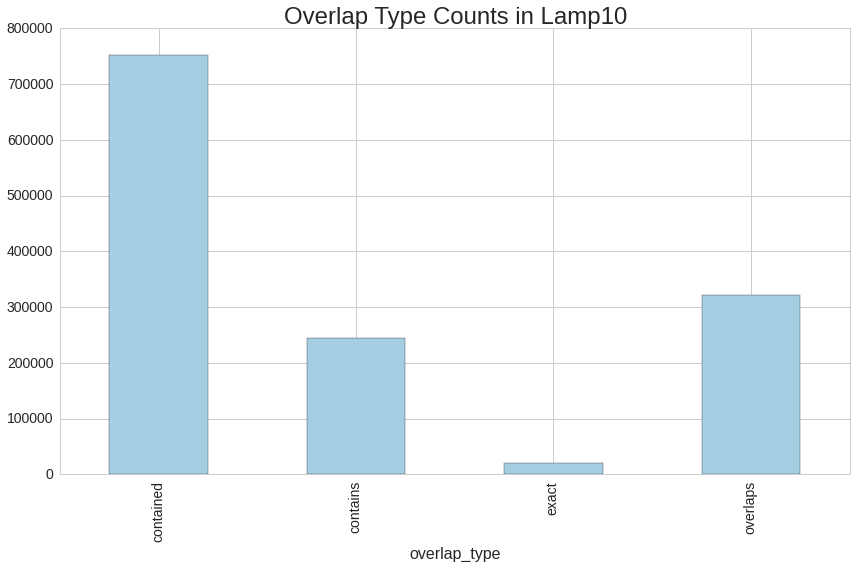

/home/camille/w/2015-petMarSB/notebooks/lamp10_overlap_type_counts.svg

In [45]:
with FigManager('lamp10_overlap_type_counts', figsize=norm_size, show=True) as (fig, ax):
    lamp10_overlaps[lamp10_overlaps.feature.isin(['exon', 'CDS', 'gene'])].\
        groupby('overlap_type').count().length.plot(kind='bar', fig=fig, ax=ax)
    ax.set_title('Overlap Type Counts in Lamp10')
FileLink('lamp10_overlap_type_counts.svg')

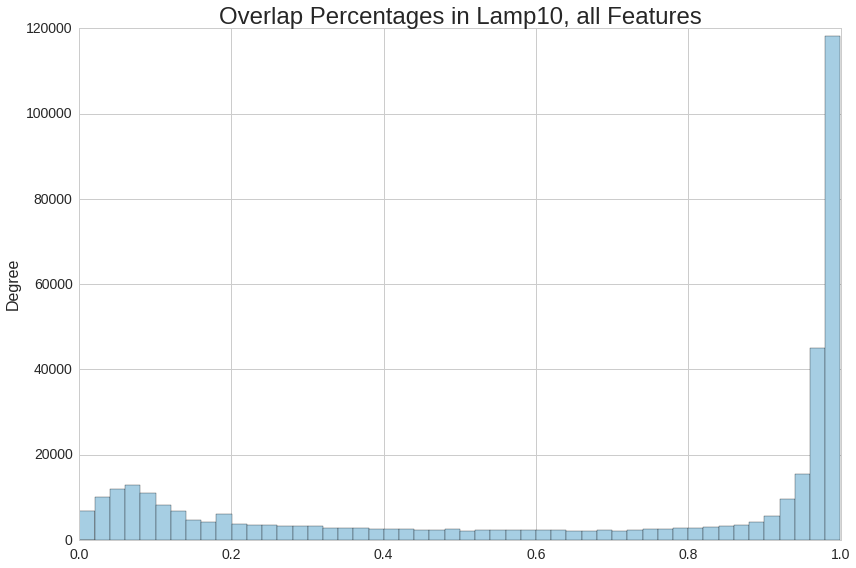

/home/camille/w/2015-petMarSB/notebooks/lamp10_overlap_percentages_all.svg

In [46]:
with FigManager('lamp10_overlap_percentages_all', figsize=norm_size, show=True) as (fig, ax):
    lamp10_overlaps[lamp10_overlaps.overlap_type == 'overlaps'].percent.plot(kind='hist', fig=fig, ax=ax, bins=50)
    ax.set_title('Overlap Percentages in Lamp10, all Features')
FileLink('lamp10_overlap_percentages_all.svg')

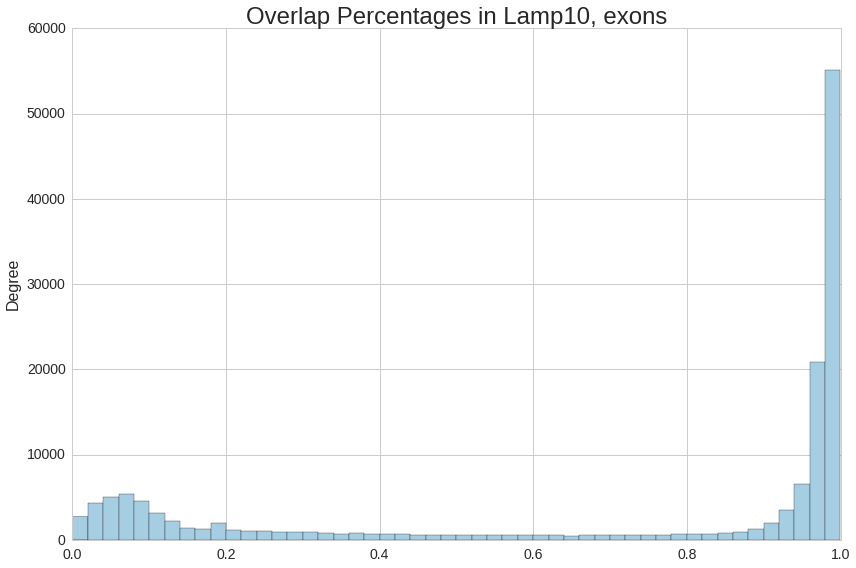

/home/camille/w/2015-petMarSB/notebooks/lamp10_overlap_percentages_exons.svg

In [47]:
with FigManager('lamp10_overlap_percentages_exons', figsize=norm_size, show=True) as (fig, ax):
    lamp10_overlaps[(lamp10_overlaps.overlap_type == 'overlaps') & \
                    (lamp10_overlaps.feature == 'exon')].percent.plot(kind='hist', 
                                                                                             fig=fig, ax=ax, bins=50)
    ax.set_title('Overlap Percentages in Lamp10, exons')
FileLink('lamp10_overlap_percentages_exons.svg')

TODO
1. Normalize vs. amount of genome covered by features
2. Use lamp00 as control for this method X
3. Pull out overlapped for more comparison X
4. Do again with only transcripts mapping to genome + other and do same process
5. Graph align old dna, new dna; transcripts
6. CEGMA 

In [150]:
store.close()

In [63]:
t = itree.IntervalTree()

In [45]:
t[0:5] = 'a'
t[3:8] = 'b'

In [46]:
t

IntervalTree([Interval(0, 5, 'a'), Interval(3, 8, 'b')])

In [62]:
t

IntervalTree([Interval(1, 202, sseqid      GL477774
pident         98.02
length           202
mismatch           4
gapopen            0
qstart             1
qend             202
sstart          7066
send            6865
evalue         2e-95
bitscore         351
Name: c423249_g1_i1, dtype: object)])

In [56]:
lamp10_pM_df.ix['c423249_g1_i1']

,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
c423249_g1_i1,GL477774,98.02,202,4,0,1,202,7066,6865,2.000000e-95,351
c423249_g1_i1,GL480428,93.56,202,13,0,1,202,9476,9677,2.000000e-80,302
c423249_g1_i1,GL479112,91.58,202,17,0,1,202,9775,9574,8.000000e-74,279
c423249_g1_i1,GL484021,91.58,202,16,1,1,202,4149,3949,3.000000e-73,278
c423249_g1_i1,GL481484,91.04,201,18,0,1,201,169036,169236,1.000000e-71,272
c423249_g1_i1,GL482931,89.11,202,22,0,1,202,11304,11103,2.000000e-65,252


In [67]:
for key, row in lamp10_pM_df.ix['c423249_g1_i1'].iterrows():
    start = min(row.qstart, row.qend)
    end = max(row.qstart, row.qend)
    t[start:end] = row.sseqid

In [69]:
t.merge_overlaps()

In [70]:
t

IntervalTree([Interval(1, 202)])

In [77]:
db = {}

In [78]:
bar = pyprind.ProgBar(len(lamp10_pM_df), stream=1, title='Building BLAST interval trees')
for query, row in lamp10_pM_df.iterrows():
    bar.update()
    subject = row.sseqid
    if query not in db:
        db[query] = itree.IntervalTree()
    if subject not in db:
        db[subject] = itree.IntervalTree()
    
    qstart = min(row.qstart, row.qend)
    qend = max(row.qstart, row.qend)
    db[query][qstart:qend] = subject
    
    sstart = min(row.sstart, row.send)
    send = max(row.sstart, row.send)
    db[subject][sstart:send] = query

Building BLAST interval trees
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 863.877 sec


In [80]:
db['c423249_g1_i1']

IntervalTree([Interval(1, 201, 'GL481484'), Interval(1, 202, 'GL477774'), Interval(1, 202, 'GL479112'), Interval(1, 202, 'GL480428'), Interval(1, 202, 'GL482931'), Interval(1, 202, 'GL484021')])

In [81]:
db['GL481484']

IntervalTree([Interval(122, 159, 'c324467_g1_i1'), Interval(122, 159, 'c324467_g1_i2'), Interval(191, 341, 'c337672_g2_i1'), Interval(191, 341, 'c337672_g2_i2'), Interval(191, 404, 'c348062_g1_i2'), Interval(252, 404, 'c348062_g1_i1'), Interval(259, 668, 'c351170_g2_i2'), Interval(319, 668, 'c351170_g2_i3'), Interval(472, 889, 'c349309_g3_i1'), Interval(593, 634, 'c379082_g1_i1'), Interval(1105, 1141, 'c257255_g1_i1'), Interval(1260, 1358, 'c350846_g3_i1'), Interval(1439, 1481, 'c345161_g1_i5'), Interval(1502, 1575, 'c364369_g4_i1'), Interval(1502, 1576, 'c364369_g2_i1'), Interval(1502, 1576, 'c364369_g2_i2'), Interval(1591, 1739, 'c42347_g1_i1'), Interval(2658, 2704, 'c351836_g2_i1'), Interval(3069, 3199, 'c42347_g1_i1'), Interval(3167, 3199, 'c341733_g1_i1'), Interval(3378, 3415, 'c352823_g3_i3'), Interval(3378, 3564, 'c352823_g3_i2'), Interval(3378, 3569, 'c352823_g3_i1'), Interval(3573, 3886, 'c360935_g5_i1'), Interval(3660, 3868, 'c364099_g8_i1'), Interval(3943, 4158, 'c192354_g1_